In [12]:
import os
import tensorflow as tf
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt

from tensorflow import keras
from tensorflow.keras import layers

import tensorflow.keras.utils as imgg

size=(299,299)

tf.config.list_physical_devices('GPU')

num_classes = 19

training_path = 'D:\\Projects\\inz\\dataset700\\train'
testing_path = 'D:\\Projects\\inz\\dataset700\\test'
validation_path = 'D:\\Projects\\inz\\dataset700\\valid'

class_names = ['agate','amethyst','azurite','calcite','chrysocolla','citrine','emerald','gypsum','labradorite','malachite','opal','pyrite','quartz','ruby','smoky quartz','topaz','tourmaline','turquoise','wulfenite']
class_names_label = {class_name:i for i, class_name in enumerate(class_names)}


train = imgg.image_dataset_from_directory(
    training_path, image_size = (size)
)

validation = imgg.image_dataset_from_directory(
    validation_path, image_size = (size)
)


test = imgg.image_dataset_from_directory(
    testing_path, image_size = (size)
)

Found 8530 files belonging to 19 classes.
Found 1700 files belonging to 19 classes.
Found 1704 files belonging to 19 classes.


In [13]:
from pathlib import Path
import imghdr

data_dir = validation_path
image_extensions = [".png", ".jpg"]  

img_type_accepted_by_tf = ["bmp", "gif", "jpeg", "png"]
for filepath in Path(data_dir).rglob("*"):
    if filepath.suffix.lower() in image_extensions:
        img_type = imghdr.what(filepath)
        if img_type is None:
            print(f"{filepath} is not an image")
        elif img_type not in img_type_accepted_by_tf:
            print(f"{filepath} is a {img_type}, not accepted by TensorFlow")

In [14]:
print(train)
print(validation)
print(test)

<BatchDataset element_spec=(TensorSpec(shape=(None, 299, 299, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>
<BatchDataset element_spec=(TensorSpec(shape=(None, 299, 299, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>
<BatchDataset element_spec=(TensorSpec(shape=(None, 299, 299, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>


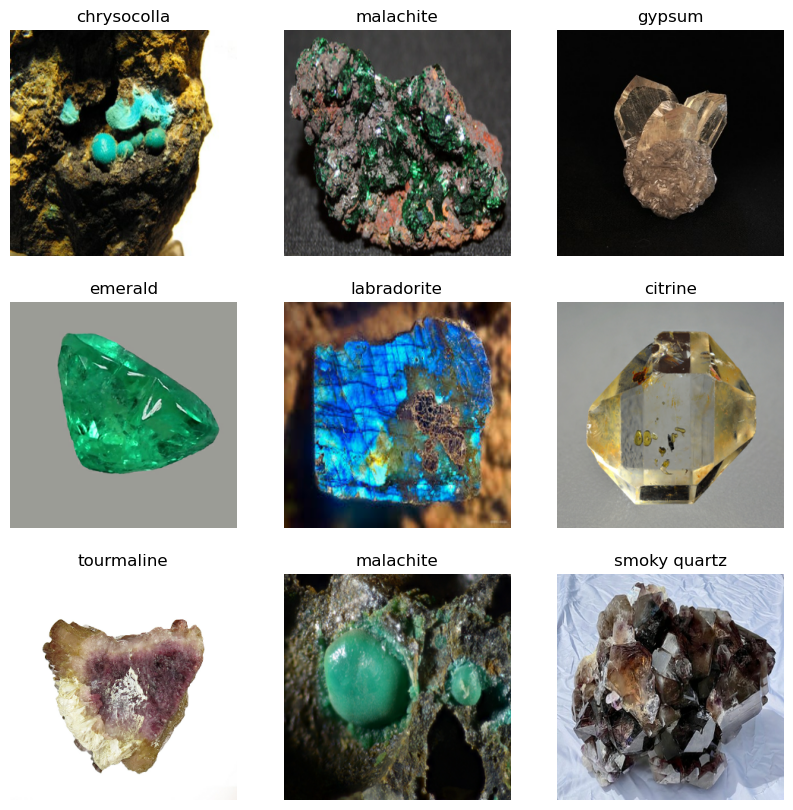

In [15]:
len(train)
plt.figure(figsize=(10, 10))
for images, labels in train.take(1):
        for i in range(9):
            ax = plt.subplot(3, 3, i + 1)
            plt.imshow(images[i].numpy().astype("uint8"))
            plt.title(class_names[labels[i]])
            plt.axis("off")

In [16]:
from keras.applications import Xception
from tensorflow.keras.applications import VGG16
base_model = Xception(weights='imagenet', include_top=False, input_shape=(299, 299, 3))


In [17]:
model = keras.Sequential(
  [
  base_model,
  tf.keras.layers.Conv2D(128, kernel_size=(3, 3), activation='relu'),
  tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dense(19, activation='softmax')
  ]
)

In [18]:
model.input_shape

(None, 299, 299, 3)

In [19]:
model.output_shape

(None, 19)

In [20]:
model.compile(
    loss=tf.keras.losses.SparseCategoricalCrossentropy(), 
    optimizer='adagrad', 
    metrics=['accuracy'])

In [21]:
history = model.fit(train, validation_data = validation, epochs=15)

Epoch 1/15
267/267 [==============================] - 161s 588ms/step - loss: 1.8319 - accuracy: 0.4361 - val_loss: 1.2680 - val_accuracy: 0.5953
Epoch 2/15
267/267 [==============================] - 155s 580ms/step - loss: 0.9104 - accuracy: 0.7077 - val_loss: 0.9796 - val_accuracy: 0.6865
Epoch 3/15
267/267 [==============================] - 155s 581ms/step - loss: 0.5737 - accuracy: 0.8168 - val_loss: 0.9188 - val_accuracy: 0.6982
Epoch 4/15
267/267 [==============================] - 156s 582ms/step - loss: 0.3969 - accuracy: 0.8822 - val_loss: 0.8781 - val_accuracy: 0.7229
Epoch 5/15
267/267 [==============================] - 155s 582ms/step - loss: 0.2686 - accuracy: 0.9232 - val_loss: 0.8841 - val_accuracy: 0.7159
Epoch 6/15
267/267 [==============================] - 155s 581ms/step - loss: 0.1876 - accuracy: 0.9537 - val_loss: 0.9032 - val_accuracy: 0.7212
Epoch 7/15
267/267 [==============================] - 155s 581ms/step - loss: 0.1343 - accuracy: 0.9726 - val_loss: 0.9155 -

In [23]:
!mkdir -p saved_model
model.save('inz_model/model_with_transfer_299')

A subdirectory or file -p already exists.
Error occurred while processing: -p.
A subdirectory or file saved_model already exists.
Error occurred while processing: saved_model.


INFO:tensorflow:Assets written to: inz_model/model_with_transfer_299\assets


INFO:tensorflow:Assets written to: inz_model/model_with_transfer_299\assets


In [24]:
results = model.evaluate(test)
print("test loss, test acc:", results)


54/54 [==============================] - 7s 114ms/step - loss: 0.9471 - accuracy: 0.7477
test loss, test acc: [0.9471089243888855, 0.7476525902748108]


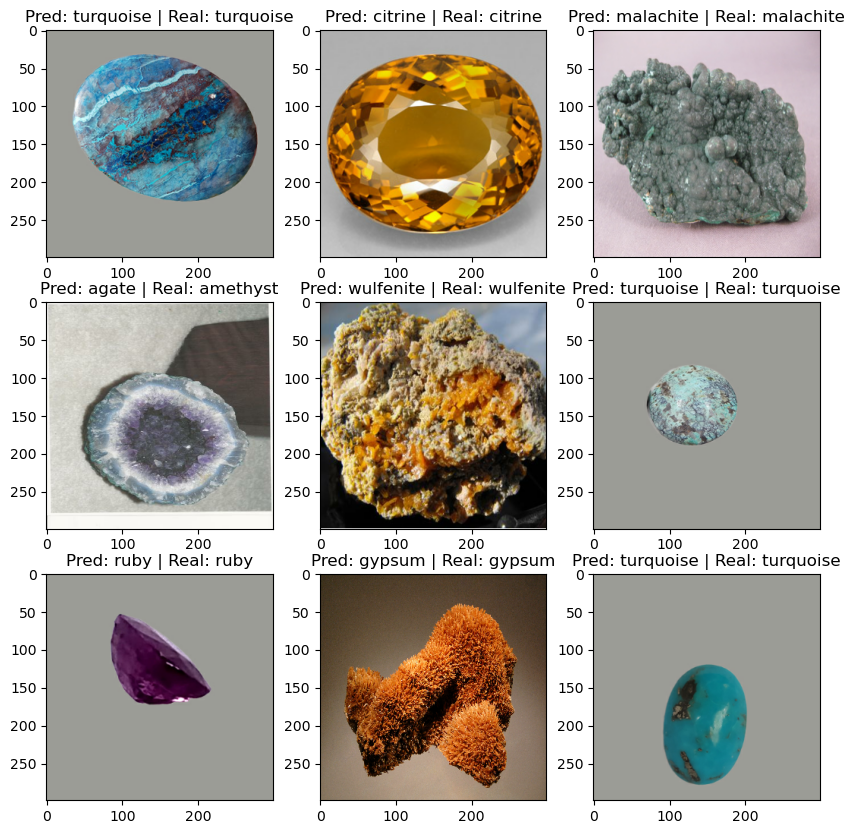

In [25]:
plt.figure(figsize=(10, 10))
for images, labels in test.take(1):
    classifications = model(images)
    
    for i in range(9):
        plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        predicted_label = tf.argmax(classifications[i]).numpy()
        plt.title("Pred: " + class_names[predicted_label] + " | Real: " + class_names[labels[i]])
        

In [26]:
predictions = model.predict(test)
print("predictions shape:", predictions.shape)

54/54 [==============================] - 7s 111ms/step
predictions shape: (1704, 19)


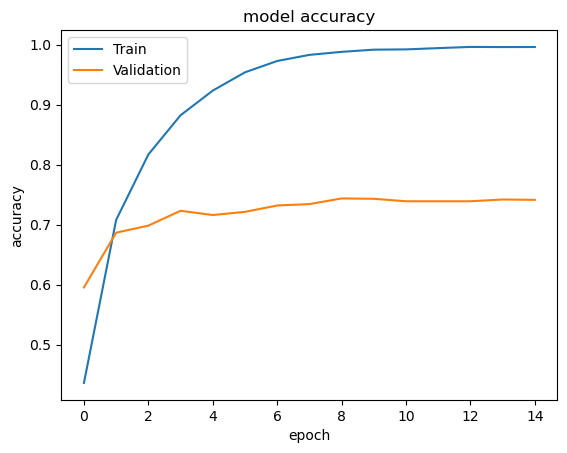

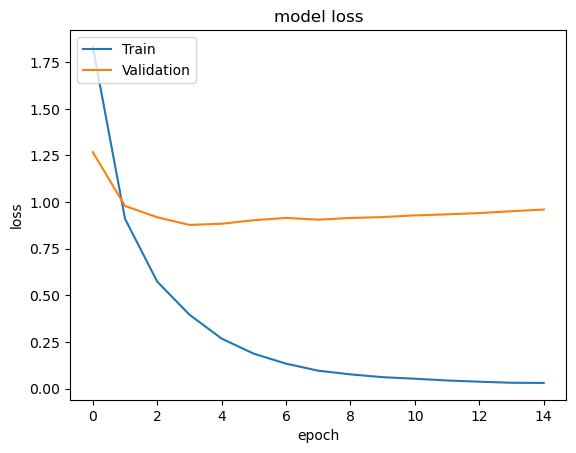

In [27]:
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [28]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

predicted_labels_list = []
true_labels_list = []

for images, labels in test:

    predicted_labels = model.predict(images)
    predicted_labels = np.argmax(predicted_labels, axis=1)

    predicted_labels_list.extend(predicted_labels)
    true_labels_list.extend(labels.numpy())



1/1 [==============================] - 1s 606ms/step


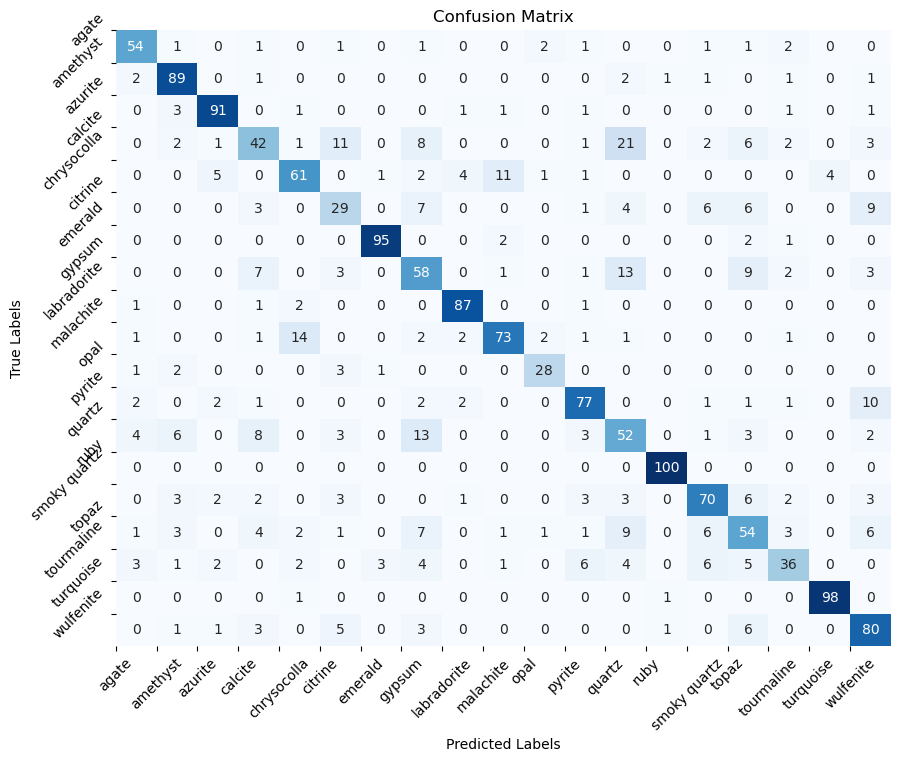

In [29]:
#Confusion Matrix
cm = confusion_matrix(true_labels_list, predicted_labels_list)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.xticks(ticks=np.arange(num_classes), labels=class_names, rotation=45)
plt.yticks(ticks=np.arange(num_classes), labels=class_names, rotation=45)
plt.show()